In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

In [2]:
# Please update the file path for the tradelog data. Download data from https://www.asxenergy.com.au/tradelog.
file_path = r'C:\Users\wwang2\OneDrive - ACCC\Desktop\Grad\R4_AER_EPR\Analysing price and volume trends in ASX energy contracts\trades.csv'

In [3]:
# Please update the selections for contract type, region, expiry time, year and etc for the analysis to be performed.
contract = 'Base'
state = 'NSW'
expiry = 'Q1'
years = [2022, 2023, 2024, 2025, 2026]

In [4]:
# Define the mappings from the ASX electricity contract cheat sheet
contract_codes = {
    'B': 'Base', 'P': 'Peak', 'G': 'Cap', # $300 cap
    'H': 'Base strip', 'D': 'Peak strip', 'R': 'Cap strip'
}

region_codes = {
    'N': 'NSW', 'Q': 'QLD', 'V': 'VIC', 'S': 'SA'
}

expiry_month_codes = {
    'F': 'JAN', 'G': 'FEB', 'H': 'MAR', 'J': 'APR', 
    'K': 'MAY', 'M': 'JUN', 'N': 'JUL', 'Q': 'AUG', 
    'U': 'SEP', 'V': 'OCT', 'X': 'NOV', 'Z': 'DEC'
}

quarter_codes = {
    'H': 'Q1', 'M': 'Q2', 'U': 'Q3', 'Z': 'Q4'
}

In [5]:
# Function to decode the product code to plain English
def decode(code):
    match = re.match(r'([A-Z])([A-Z])([A-Z])(\d{4})([A-Z]?)(\d{7})?', code)
    
    if match:
        contract = contract_codes.get(match.group(1), '')
        region = region_codes.get(match.group(2), '')
        expiry = quarter_codes.get(match.group(3), '')
        year = match.group(4)
        option_type = match.group(5)
        strike_price = match.group(6)
        
        if option_type == "F":
            return f"{contract} {region} {expiry} {year}"
        elif option_type in ["C", "P"]:
            option = "Call option" if option_type == "C" else "Put option"
            strike_price_dollars = f"${int(strike_price) / 100:.2f}"
            return f"{contract} {region} {expiry} {year} {option} with a strike price of {strike_price_dollars}"
    
    return "Invalid code"

In [6]:
# Function to encode plain English to product code
def encode(plain_english):
    parts = plain_english.split()
    
    if len(parts) == 4:
        contract_code = list(contract_codes.keys())[list(contract_codes.values()).index(parts[0])]
        region_code = list(region_codes.keys())[list(region_codes.values()).index(parts[1])]
        expiry_code = list(quarter_codes.keys())[list(quarter_codes.values()).index(parts[2])]
        year_code = parts[3]
        
        return f"{contract_code}{region_code}{expiry_code}{year_code}F"\
    
    elif len(parts) == 8:
        contarct_code = list(contract_codes.keys())[list(contract_codes.values()).index(parts[0])]
        region_code = list(region_codes.keys())[list(region_codes.values()).index(parts[1])]
        expiry_code = list(quarter_codes.keys())[list(quarter_codes.values()).index(parts[2])]
        year_code = parts[3]
        option_type = "C" if parts[4] == "Call" else "P"
        strike_price_cents = f"{int(float(parts[-1][1:]) * 100):07d}"
        
        return f"{contract_code}{region_code}{expiry_code}{year_code}{option_type}{strike_price_cents}"
    
    return "Invalid input"

In [7]:
# Example usage of the above encode and decode functions
code = "BNH2022C0006000"
plain_english = "Cap QLD Q4 2025"

decoded = decode(code)
encoded = encode(plain_english)

print(f"Decoded: {decoded}")
print(f"Encoded: {encoded}")

Decoded: Base NSW Q1 2022 Call option with a strike price of $60.00
Encoded: GQZ2025F


In [8]:
def generate_trade_codes(contract, state, expiry, years):
    trade_codes = []
    for year in years:
        trade_code = f"{contract} {state} {expiry} {year}"
        trade_codes.append(encode(trade_code))
    return trade_codes

trade_codes_of_interest = generate_trade_codes(contract, state, expiry, years)
print(trade_codes_of_interest)

['BNH2022F', 'BNH2023F', 'BNH2024F', 'BNH2025F', 'BNH2026F']


In [9]:
def read_trade_data(file_path):
    # Skip the first line with the separator information
    df = pd.read_csv(file_path, skiprows=1)
    df['Date'] = pd.to_datetime(df['Date'])  # Convert Date column to datetime format
    return df

In [10]:
def process_trade_data(df, trade_code):
    # Filter the dataframe by the specified trade code
    filtered_df = df[df['Code'] == trade_code]
    
    # Group by date and calculate the required sums
    grouped_df = filtered_df.groupby('Date').agg({
        'Cleared Volume': 'sum',
        'Face Value': 'sum',
        'Volume x MWh': 'sum'
    }).reset_index()
    
    # Rename the columns
    grouped_df.rename(columns={
        'Cleared Volume': 'Daily contracts traded',
        'Face Value': 'Daily dollars traded',
        'Volume x MWh': 'Daily MWh traded'
    }, inplace=True)
    
    # Calculate the daily volume weighted average price in $/MWh
    grouped_df['Daily average price'] = grouped_df['Daily dollars traded'] / grouped_df['Daily MWh traded']
    
    # Calculate the cumulative sums
    grouped_df['Cumulative MWh traded'] = grouped_df['Daily MWh traded'].cumsum()
    grouped_df['Cumulative dollars traded'] = grouped_df['Daily dollars traded'].cumsum()
    
    # Calculate the cumulative trade volume-weighted average price in $/MWh
    grouped_df['Cumulative average price'] = grouped_df['Cumulative dollars traded'] / grouped_df['Cumulative MWh traded']
    
    return grouped_df

In [11]:
def create_trade_chart(df, plain_english_name):
    # Convert Date column to datetime format if not already
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])
    
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots(figsize=(14, 10), dpi=150)

    # Plot Daily average price and Cumulative average price on the primary vertical axis
    ax1.plot(df['Date'], df['Daily average price'], color='tab:blue', label='Daily Average Price')
    ax1.plot(df['Date'], df['Cumulative average price'], color='tab:orange', label='Cumulative Average Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average price ($/MWh)')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Create a secondary y-axis to plot Daily MWh traded and Cumulative MWh traded
    ax2 = ax1.twinx()
    ax2.plot(df['Date'], df['Daily MWh traded'], color='tab:green', linestyle='--', label='Daily MWh Traded')
    ax2.plot(df['Date'], df['Cumulative MWh traded'], color='tab:red', linestyle='--', label='Cumulative MWh Traded')
    ax2.set_ylabel('MWh traded')
    ax2.legend(loc='upper right')

    plt.title(plain_english_name)
    
    #plt.show()

    # Save the chart to the specified file path
    plt.savefig(f'results/{plain_english_name}.png')
    plt.close()

In [30]:
def plot_summary_df(summary_df, summary_chart_title):
    # Convert Date column to datetime format if not already
    if not pd.api.types.is_datetime64_any_dtype(summary_df['Date']):
        summary_df['Date'] = pd.to_datetime(summary_df['Date'])
    
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots(figsize=(14, 10), dpi=150)

    # Plot all Daily average prices on the primary vertical axis
    daily_avg_price_cols = [col for col in summary_df.columns if 'Cumulative average price' in col]
    for col in daily_avg_price_cols:
        ax1.plot(summary_df.index, summary_df[col], label=col)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average price ($/MWh)')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Create a secondary y-axis to plot all Daily MWh traded
    ax2 = ax1.twinx()
    daily_mwh_traded_cols = [col for col in summary_df.columns if 'Cumulative MWh traded' in col]
    for col in daily_mwh_traded_cols:
        # ax2.plot(summary_df.index, summary_df[col], linestyle='--', label=col)
        ax2.fill_between(summary_df.index, summary_df[col], alpha=0.5, label=col)
    
    ax2.set_ylabel('MWh traded')
    ax2.legend(loc='upper right')

    plt.title(summary_chart_title)
    
    plt.show()
    plt.savefig(f'results/{summary_chart_title}.png')
    plt.close()

In [13]:
df = read_trade_data(file_path)

In [25]:
# print(list(df.columns))
# df.head()

In [31]:
# Initialize an empty summary dataframe with all possible dates
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
empty_df = pd.DataFrame({'Date': all_dates})
summary_df = empty_df

In [32]:
# Process and save dataframes for each trade code
for trade_code in trade_codes_of_interest:
    result_df = process_trade_data(df, trade_code)
    plain_english_name = decode(trade_code)
    result_df.to_csv(f'results/{plain_english_name}.csv', index=False) # save the table for this trade code
    
    # Create and save the chart for the current trade code
    create_trade_chart(result_df, plain_english_name)
    
    # Merge result_df with summary_df to align dates
    result_df_full = empty_df.merge(result_df, on='Date', how='left')
    
    # Forward fill missing values (does not apply beyond the last trade for that contract)
    last_date = result_df['Date'].max()
    result_df_full.loc[result_df_full['Date'] <= last_date] = result_df_full.loc[result_df_full['Date'] <= last_date].fillna(method='ffill')
    
    # Add columns to the summary dataframe with renamed columns
    summary_df[f'Daily average price for {plain_english_name}'] = result_df_full['Daily average price']
    summary_df[f'Cumulative average price for {plain_english_name}'] = result_df_full['Cumulative average price']
    summary_df[f'Daily MWh traded for {plain_english_name}'] = result_df_full['Daily MWh traded']
    summary_df[f'Cumulative MWh traded for {plain_english_name}'] = result_df_full['Cumulative MWh traded']

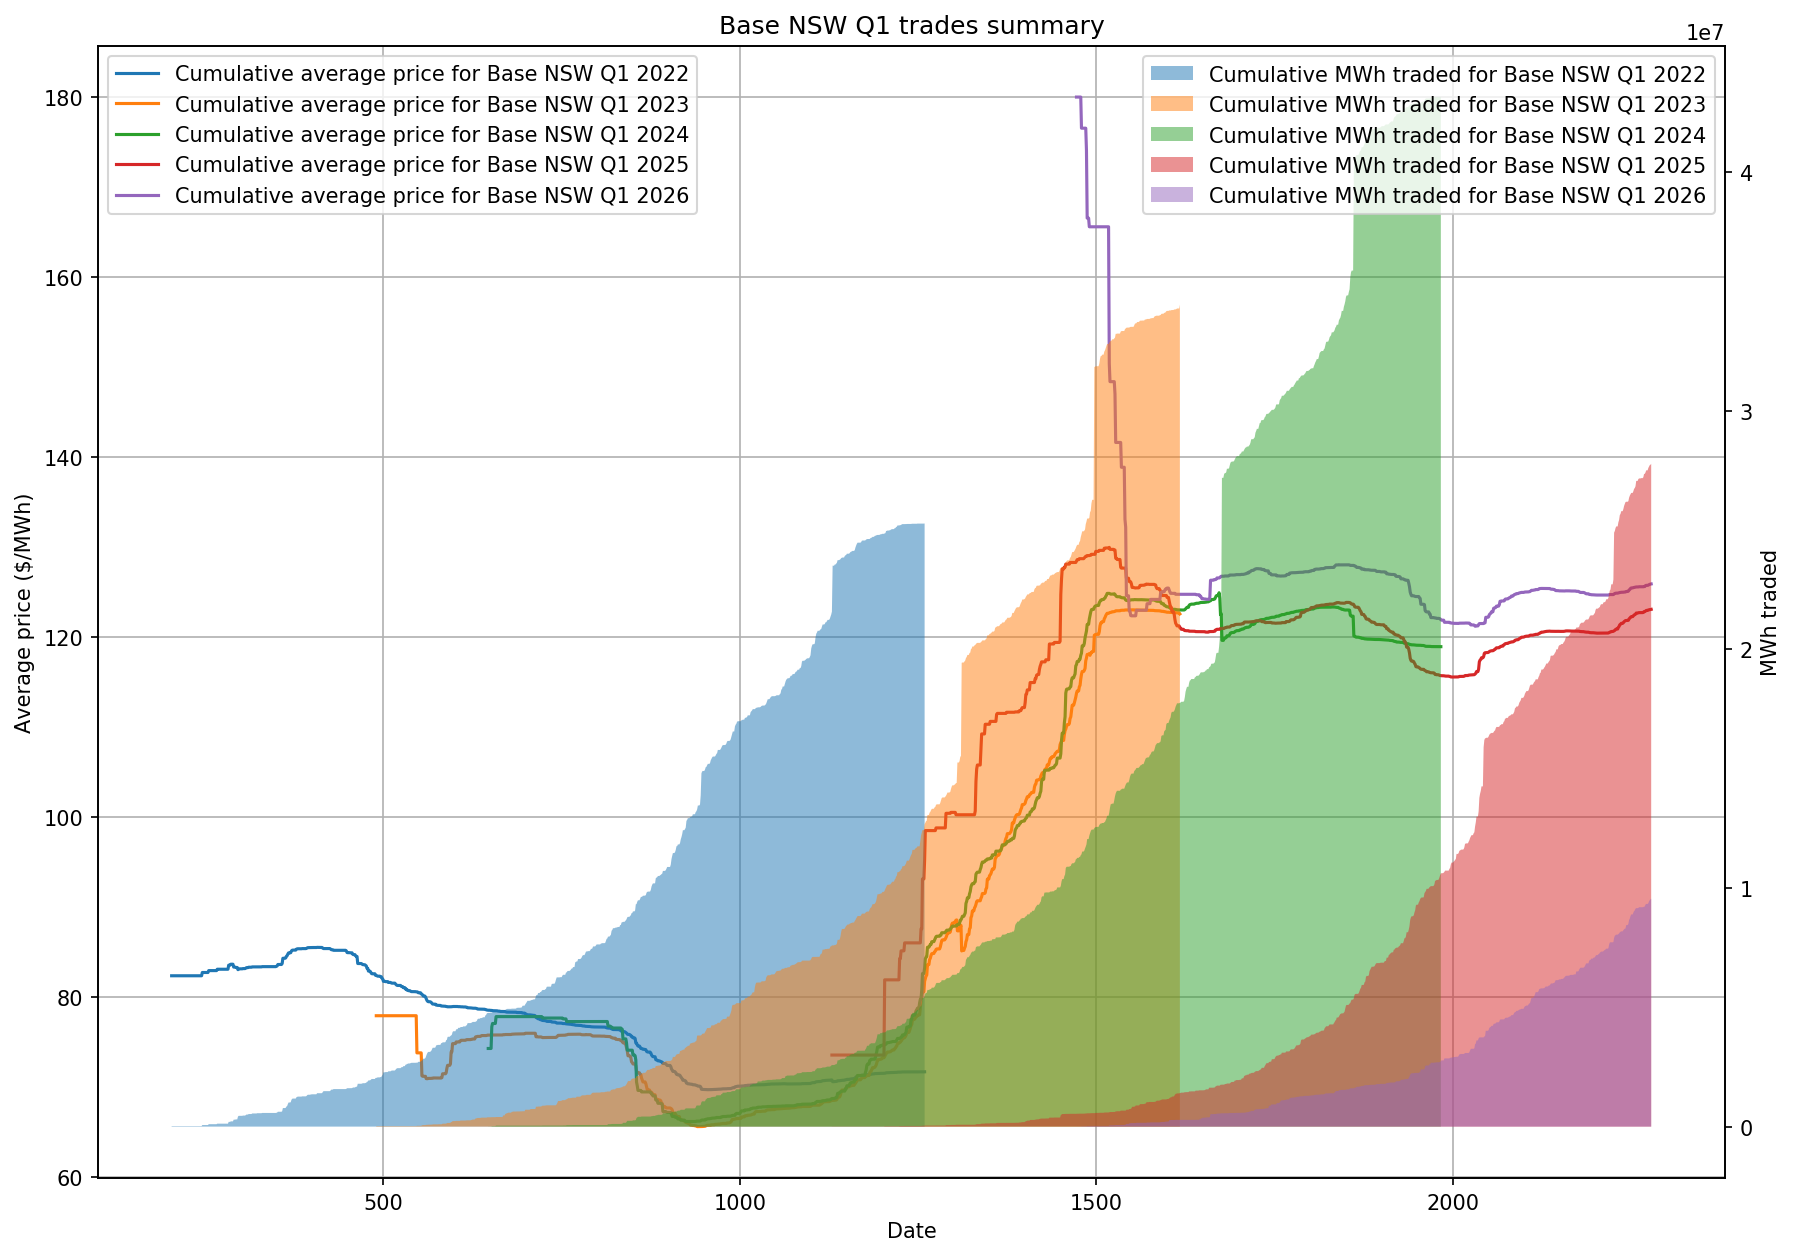

In [34]:
summary_title = f"{contract} {state} {expiry} trades summary"
summary_df.to_csv(f'results/{summary_title}.csv')
plot_summary_df(summary_df, summary_title)